In [126]:
from utils import *
import pickle
import os
import numpy as np
import pandas as pd
import shap
from scipy import sparse
from IPython.display import display, HTML
import html

In [127]:
TEXT_COL = "entities"  # tokens at least have 1 letter, numbers excluded

datasets = load_dataset()  # load dataset
print(f'datasets: {datasets.keys()}')

datasets: dict_keys(['train', 'test', 'prsp', 'external'])


In [128]:
"""Load trained configuration"""
MODELS_DIR = "data/models/new"
MODEL_PATH = os.path.join(MODELS_DIR, "rmh_2012_2017_dev_SH_REFIT_ensemble_True_classifier.pickle")

with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

print("Loaded model:", type(model))

Loaded model: <class 'sklearn.calibration.CalibratedClassifierCV'>


In [129]:
def get_selected_feature_names(vectorizer, selector):
    # full vocab from vectorizer
    if hasattr(vectorizer, "get_feature_names_out"):
        full_names = vectorizer.get_feature_names_out()
    else:
        full_names = np.array(list(vectorizer.vocabulary_.keys()))

    # sklearn selector
    if hasattr(selector, "get_support"):
        mask = selector.get_support()
        return np.array(full_names)[mask]

    raise ValueError("Unknown selector type")


def fold_global_mean_abs_shap(best_model, fold_i, df, text_col, sample_idx):
    est = best_model.calibrated_classifiers_[fold_i].estimator
    vec = est[0]
    selector = est[1]
    clf = est[2]

    feat_names = get_selected_feature_names(vec, selector)

    texts = df.iloc[sample_idx][text_col].astype(str).tolist()
    X = est[0:2].transform(texts)

    if sparse.issparse(X):
        X = X.toarray()

    feat_names = feat_names[:X.shape[1]]
    X_df = pd.DataFrame(X, columns=feat_names)

    explainer = shap.TreeExplainer(clf)
    sv = explainer(X_df)
    mean_abs = np.mean(np.abs(sv.values), axis=0)

    return dict(zip(feat_names, mean_abs)), feat_names

In [130]:
SEED = 42
df_global_shap = pd.DataFrame()

for DATASET_NAME in ['train', 'test', 'prsp', 'external']:
    print('Dataset:', DATASET_NAME)
    df_ref = datasets[DATASET_NAME]
    rng = np.random.default_rng(SEED)
    N_SAMPLE = len(df_ref)
    sample_idx = rng.choice(len(df_ref), size=min(N_SAMPLE, len(df_ref)), replace=False)
    
    # compute per-fold shap importance dicts
    fold_dicts = []
    for i in range(len(model.calibrated_classifiers_)):
        d_i, feats_i = fold_global_mean_abs_shap(model, i, df_ref, TEXT_COL, sample_idx)
        fold_dicts.append(d_i)
        print(f"Fold {i}: features={len(d_i)}")
    
    # ignore folds where feature missing
    all_feats = sorted(set().union(*[set(d.keys()) for d in fold_dicts]))
    
    rows = []
    for f in all_feats:
        vals = [d[f] for d in fold_dicts if f in d]   # only where present
        rows.append({
            "feature": f,
            "mean_abs_shap": float(np.mean(vals)),
            "present_in_folds": len(vals),
            "dataset_name": DATASET_NAME,
        })
    
    df_global_ens = (pd.DataFrame(rows)
                     .sort_values("mean_abs_shap", ascending=False)
                     .reset_index(drop=True))
    
    df_global_shap = pd.concat([df_global_shap, df_global_ens], ignore_index=True)

Dataset: train
Fold 0: features=1355
Fold 1: features=1347
Fold 2: features=1315
Dataset: test
Fold 0: features=1355
Fold 1: features=1347
Fold 2: features=1315
Dataset: prsp
Fold 0: features=1355
Fold 1: features=1347
Fold 2: features=1315
Dataset: external
Fold 0: features=1355
Fold 1: features=1347
Fold 2: features=1315


In [131]:
df_global_shap

,feature,mean_abs_shap,present_in_folds,dataset_name
0,pain,0.362135,3,train
1,sob,0.181202,3,train
2,onset,0.146743,3,train
3,gcs,0.131377,3,train
4,nil,0.113230,3,train
...,...,...,...,...
7719,lac r wrist,0.000000,2,external
7720,lac r forearm,0.000000,1,external
7721,lac l wrist,0.000000,3,external
7722,lac l arm,0.000000,3,external


In [132]:
"""
Global SHAP importance comparison
Comparison: Train set vs Test/Prospective/External set
Select Top-k features to examine overlapped and unique important predictive features
"""
TOP_K = 100

df_top = (
    df_global_shap
    .sort_values(["dataset_name", "mean_abs_shap"], ascending=[True, False])
    .groupby("dataset_name")
    .head(TOP_K)
)

top_sets = {
    d: set(df_top[df_top.dataset_name == d]["feature"])
    for d in df_global_shap.dataset_name.unique()
}

train_top = top_sets["train"]

rows = []

for d, s in top_sets.items():
    if d == "train":
        continue

    overlap = train_top & s
    union = train_top | s

    rows.append({
        "dataset": d,
        "overlap_n": len(overlap),
        "train_only": len(train_top - s),
        "other_only": len(s - train_top),
    })

df_overlap = pd.DataFrame(rows).sort_values("other_only", ascending=False)
df_overlap

,dataset,overlap_n,train_only,other_only
2,external,91,9,9
1,prsp,98,2,2
0,test,99,1,1


In [133]:
train_only = {
    d: sorted(train_top - top_sets[d])
    for d in top_sets if d != "train"
}
print(f"Features only important in train set (TOP{TOP_K})")
print(train_only)

other_only = {
    d: sorted(top_sets[d] - train_top)
    for d in top_sets if d != "train"
}
print(f"Features only important in other set (TOP{TOP_K})")
print(other_only)

Features only important in train set (TOP100)
{'test': ['ett'], 'prsp': ['mgs', 'nurofen'], 'external': ['disorder', 'ett', 'heroin', 'injected', 'jump', 'mgs', 'schizophrenia', 'view', 'wine']}
Features only important in other set (TOP100)
{'test': ['drank'], 'prsp': ['rat', 'use'], 'external': ['calm', 'cuts', 'end', 'ice', 'lyrica', 'rat', 'sleeping', 'taken x', 'x panadol']}


In [134]:
"""
Global SHAP importance comparison
Comparison: Train set vs Test/Prospective/External set
Examine delta of absolute shap values
"""
def shap_delta(df_global_shap, other_dataset):
    
    train_df = df_global_shap[df_global_shap.dataset_name=="train"]
    other_df = df_global_shap[df_global_shap.dataset_name==other_dataset]

    merged = (
        train_df[["feature","mean_abs_shap"]]
        .rename(columns={"mean_abs_shap":"train_shap"})
        .merge(other_df[["feature","mean_abs_shap"]], on="feature", how="outer")
        .rename(columns={"mean_abs_shap":f"{other_dataset}_shap"})
        .fillna(0)
    )

    merged["delta"] = merged[f"{other_dataset}_shap"] - merged["train_shap"]

    return merged.sort_values("delta", ascending=False)

In [135]:
df_ext_delta = shap_delta(df_global_shap, "external")
df_ext_delta.head(30)

,feature,train_shap,external_shap,delta
1870,x,0.073169,0.167641,0.094472
1653,taken,0.063921,0.124764,0.060842
1504,states,0.022584,0.053197,0.030613
894,mg,0.040535,0.070785,0.030250
1729,took,0.038442,0.068395,0.029953
1086,pain,0.362135,0.389608,0.027474
1481,sob,0.181202,0.206942,0.025739
1554,suicidal,0.048846,0.067288,0.018442
67,approx,0.026470,0.039825,0.013355
1890,x mg,0.010133,0.022980,0.012846


In [136]:
df_ext_delta = shap_delta(df_global_shap, "test")
df_ext_delta.head(30)

,feature,train_shap,test_shap,delta
1870,x,0.073169,0.075498,0.002329
1086,pain,0.362135,0.363752,0.001617
987,nil,0.113230,0.114823,0.001592
1852,wrist,0.030615,0.032082,0.001466
1395,self,0.085133,0.086256,0.001123
250,cut,0.016880,0.017661,0.000781
374,drank,0.002073,0.002725,0.000652
1604,superficial,0.018596,0.019242,0.000646
587,harm,0.020221,0.020852,0.000630
1402,self harm,0.020915,0.021531,0.000616


In [137]:
df_ext_delta = shap_delta(df_global_shap, "prsp")
df_ext_delta.head(30)

,feature,train_shap,prsp_shap,delta
1481,sob,0.181202,0.203836,0.022634
987,nil,0.113230,0.127812,0.014582
1554,suicidal,0.048846,0.060416,0.011570
1066,onset,0.146743,0.158259,0.011516
356,direct,0.022479,0.033478,0.010999
1395,self,0.085133,0.093584,0.008451
1312,radiating,0.059564,0.065634,0.006070
1870,x,0.073169,0.078665,0.005496
1025,od,0.042100,0.046416,0.004316
298,depression,0.052153,0.056167,0.004015


## Misclassified case SHAP analysis

In [138]:
"""
Misclassified case SHAP analysis
"""
best_model = model
TEXT_COL = "entities"
LABEL_COL = "binary_SH"
with open('data/models/new/rmh_2012_2017_dev_SH_REFIT_ensemble_True_threshold.txt', 'r') as f:
    threshold = float(f.read().strip())
print('Threshold:', threshold)

Threshold: 0.3724727792226775


In [146]:
def fold_transform_to_df(best_model, fold_i, texts):
    """
    returns: X_df (DataFrame with feature names), pipe, clf for specific fold
    """
    pipe = best_model.calibrated_classifiers_[fold_i].estimator
    vec, selector, clf = pipe[0], pipe[1], pipe[2]

    feat_names = get_selected_feature_names(vec, selector)

    X = pipe[0:2].transform(texts)  # vectorizer + selector only
    X = X.toarray() if sparse.issparse(X) else np.asarray(X)

    # defensive alignment
    if X.shape[1] != len(feat_names):
        feat_names = feat_names[:X.shape[1]]

    X_df = pd.DataFrame(X, columns=feat_names)
    return X_df, pipe, clf

In [147]:
def ensemble_predict_proba(best_model, texts):
    probs = []
    for cc in best_model.calibrated_classifiers_:
        pipe = cc.estimator
        probs.append(pipe.predict_proba(texts)[:, 1])  # raw text input
    return np.mean(np.vstack(probs), axis=0)


def get_misclassified(dataset_name, label_col, text_col, threshold):
    texts = datasets[dataset_name][text_col].astype(str).tolist()
    y_true = datasets[dataset_name][label_col].values

    proba = ensemble_predict_proba(best_model, texts)
    y_pred = (proba >= threshold).astype(int)

    miss_idx = np.where(y_pred != y_true)[0]
    return miss_idx, proba, y_pred


In [148]:
# get union feature space
union_features = sorted(df_global_shap["feature"].unique())
feat2idx = {f:i for i,f in enumerate(union_features)}

In [159]:
def shap_one_fold_aligned(best_model, fold_i, text, union_features, feat2idx):
    """
    Compute shap values for one fold and align it on union features 
    """
    X_df, pipe, clf = fold_transform_to_df(best_model, fold_i, [text])

    explainer = shap.TreeExplainer(clf)
    sv = explainer(X_df)
    base = explainer.expected_value

    shap_vals = sv.values[0]  # (n_features_fold,)
    fold_feats = list(X_df.columns)

    aligned = np.zeros(len(union_features))

    for j, f in enumerate(fold_feats):
        if f in feat2idx:
            aligned[feat2idx[f]] = shap_vals[j]

    return base, aligned

In [170]:
def plot_avg_waterfall(best_model, text):
    # get average shap across folds
    all_fold_shap = []
    all_fold_base = []

    for fold_i in range(len(best_model.calibrated_classifiers_)):
        base, s = shap_one_fold_aligned(best_model, fold_i, text, union_features, feat2idx)
        all_fold_shap.append(s)
        all_fold_base.append(base)
    
    shap_avg = np.mean(all_fold_shap, axis=0)
    base_value = float(np.mean(all_fold_base))

    sv = shap.Explanation(values = shap_avg, base_values = base_value,feature_names = union_features)
    shap.plots.waterfall(sv, max_display=15)

In [182]:
def explain_one_case(best_model, dataset_name, idx, text_col, label_col, proba, y_pred, max_display=15):
    row = datasets[dataset_name].iloc[idx]
    text = str(row[text_col])
    y_true = row[label_col]

    display(HTML(f"""
    <div>
    <b>Dataset:</b> {dataset_name}<br>
    <b>Index:</b> {idx}<br>
    <b>True:</b> {y_true}<br>
    <b>Pred:</b> {int(y_pred[idx])}<br>
    <b>Proba (ensemble):</b> {float(proba[idx]):.4f}<br>
    <b>Threshold:</b> {float(threshold):.4f}<br>
    <b>{text_col}:</b><br>
    {html.escape(text)}<br>
    <b>Triage note:</b><br>
    {html.escape(str(row['triage_note']))}<br>
    </div>
    """))

    display(HTML(f"<h5>SHAP Waterfall averged by folds</h5>"))
    plot_avg_waterfall(best_model, text)

/Users/liuliuc/Desktop/Eleanor/Umel/Py_Projects/ED_Clinical/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


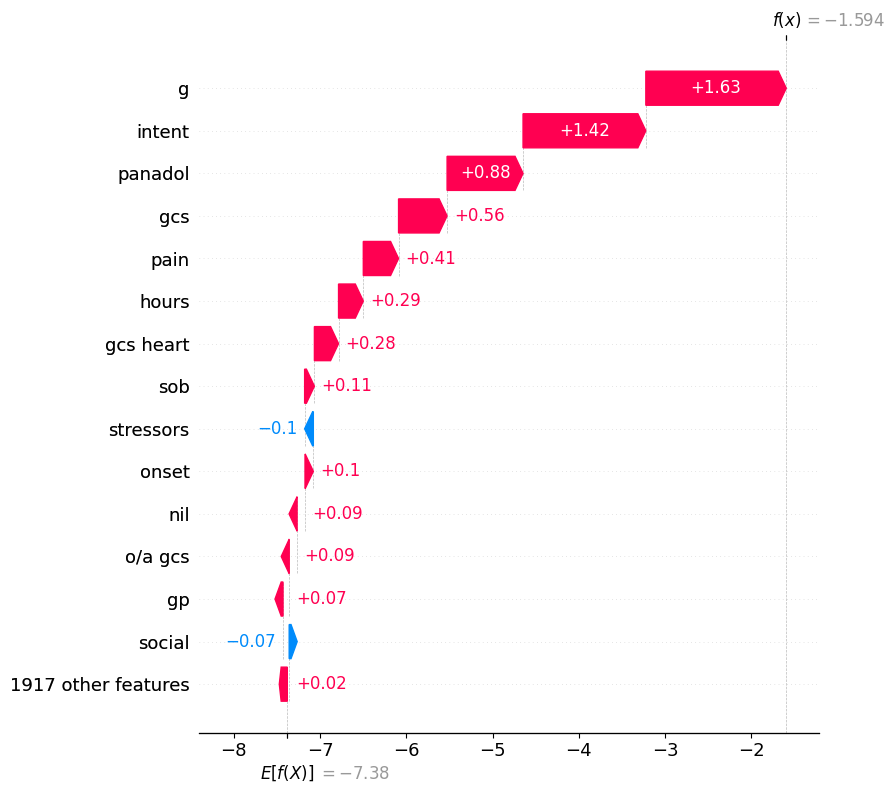

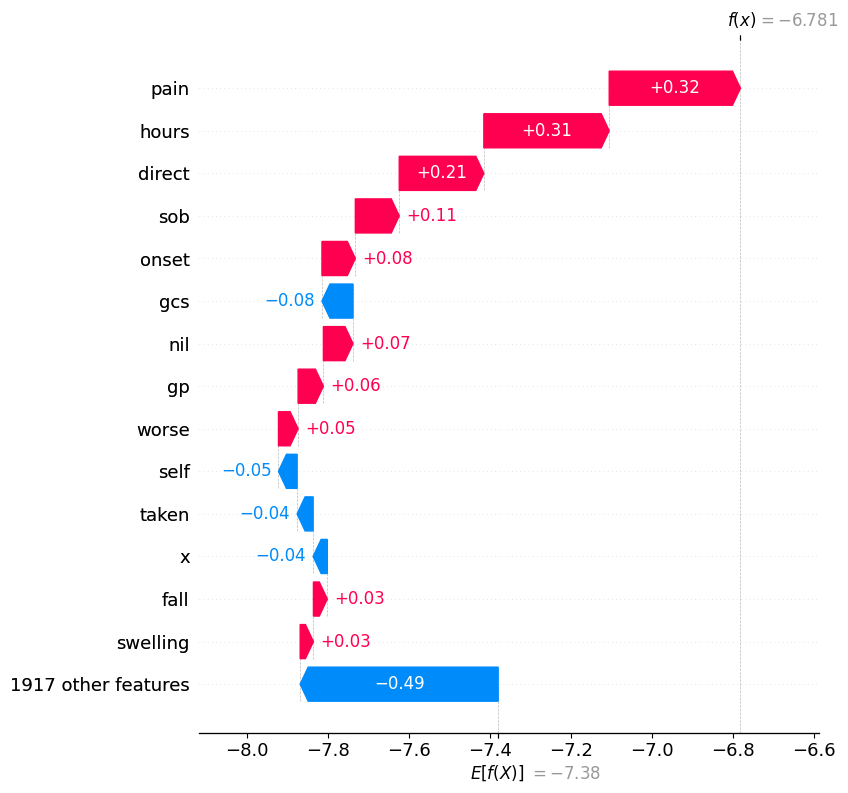

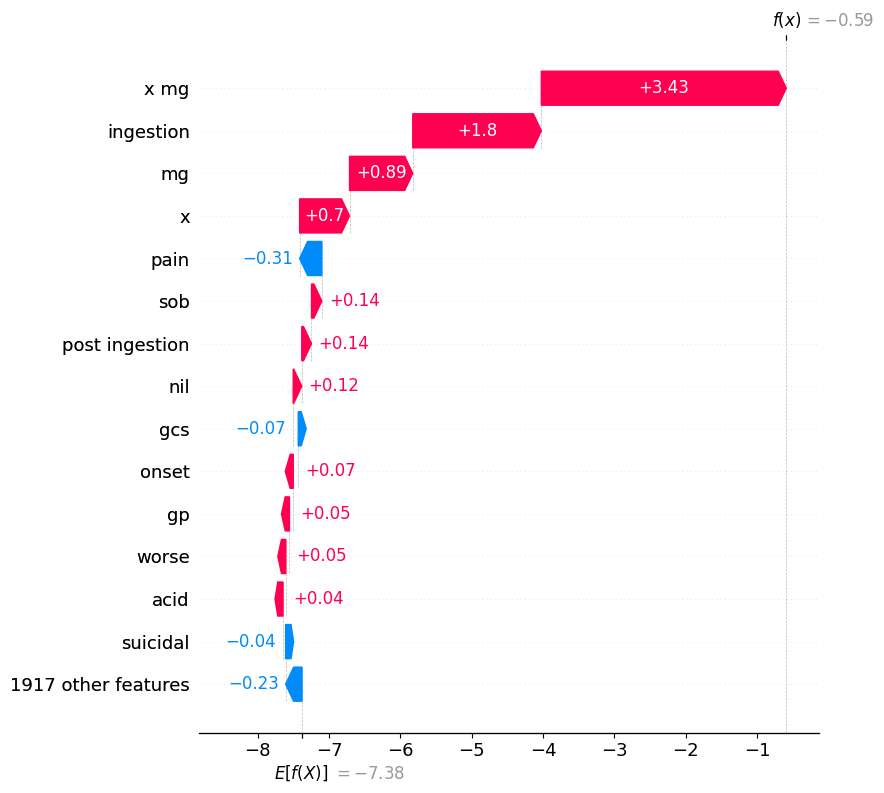

/Users/liuliuc/Desktop/Eleanor/Umel/Py_Projects/ED_Clinical/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


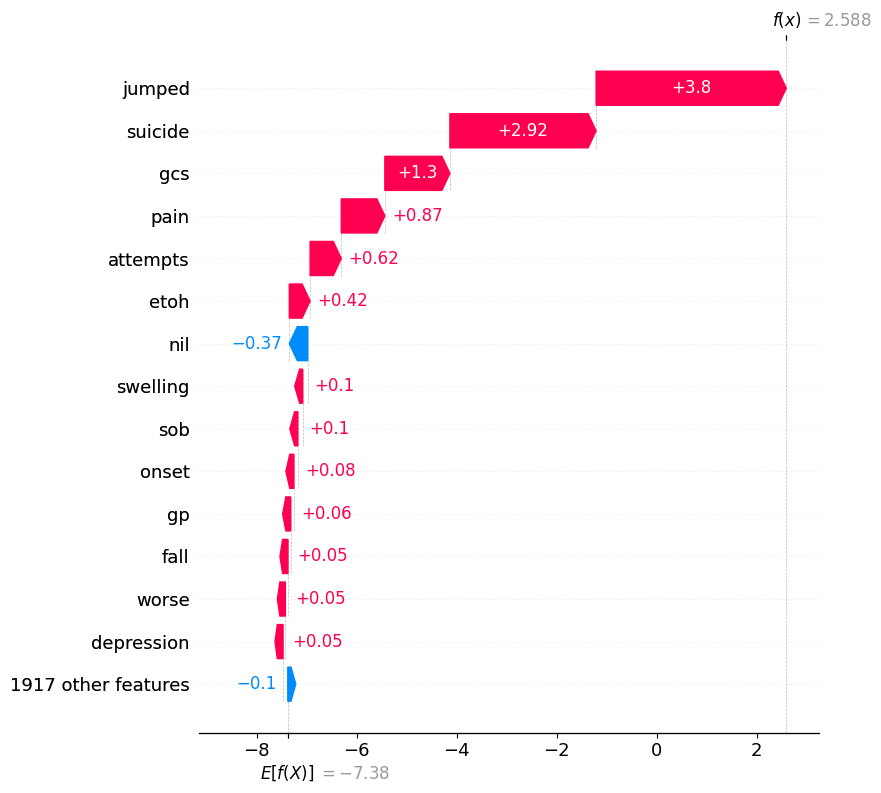

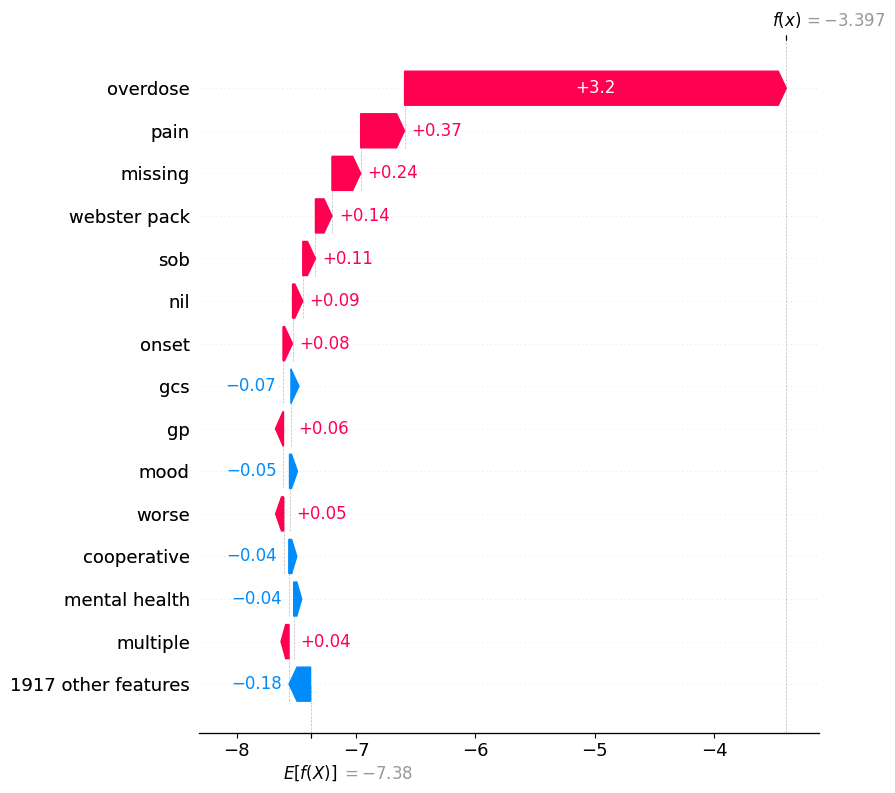

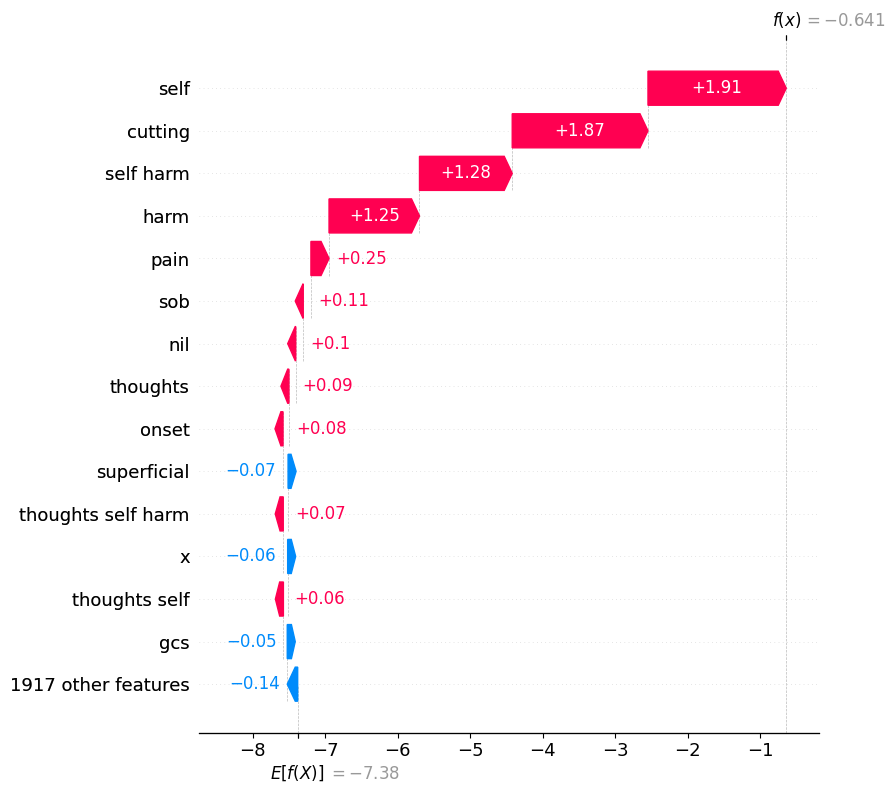

/Users/liuliuc/Desktop/Eleanor/Umel/Py_Projects/ED_Clinical/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


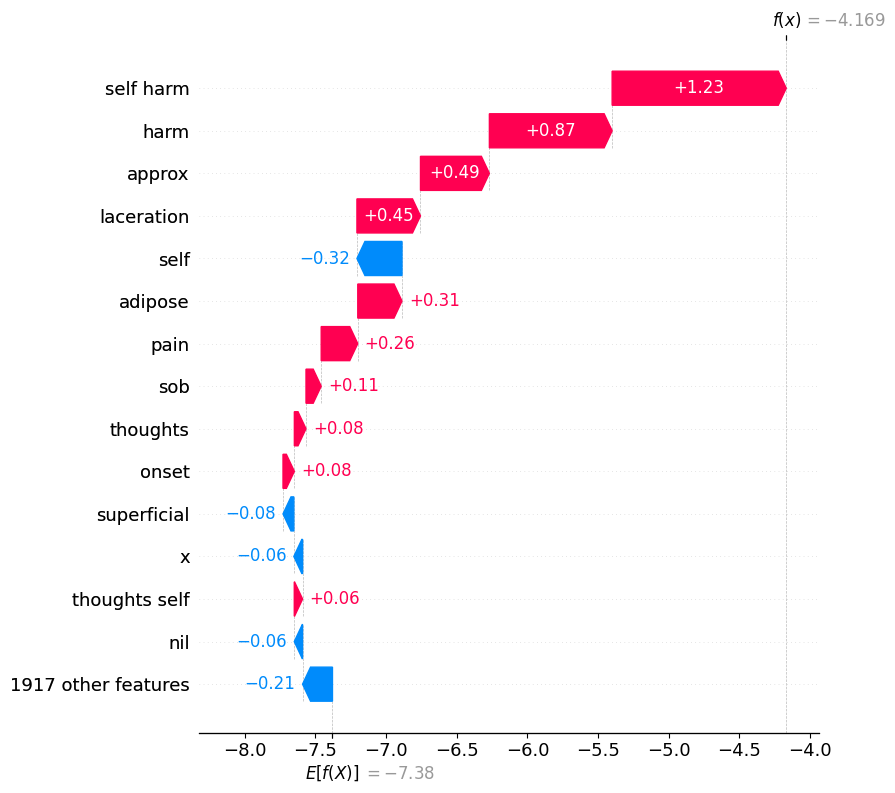

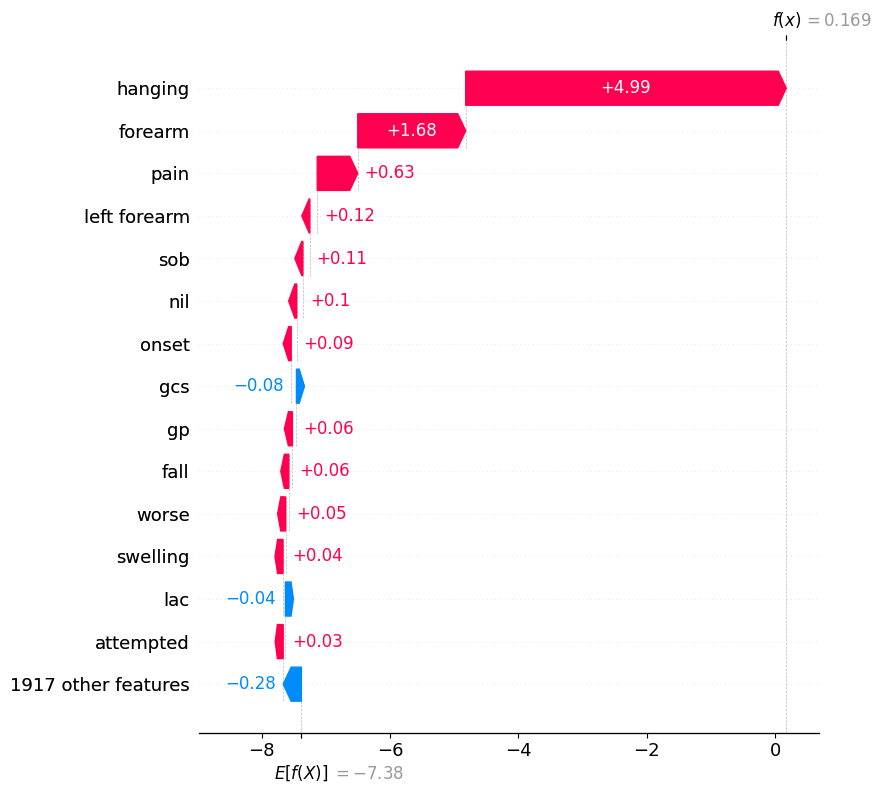

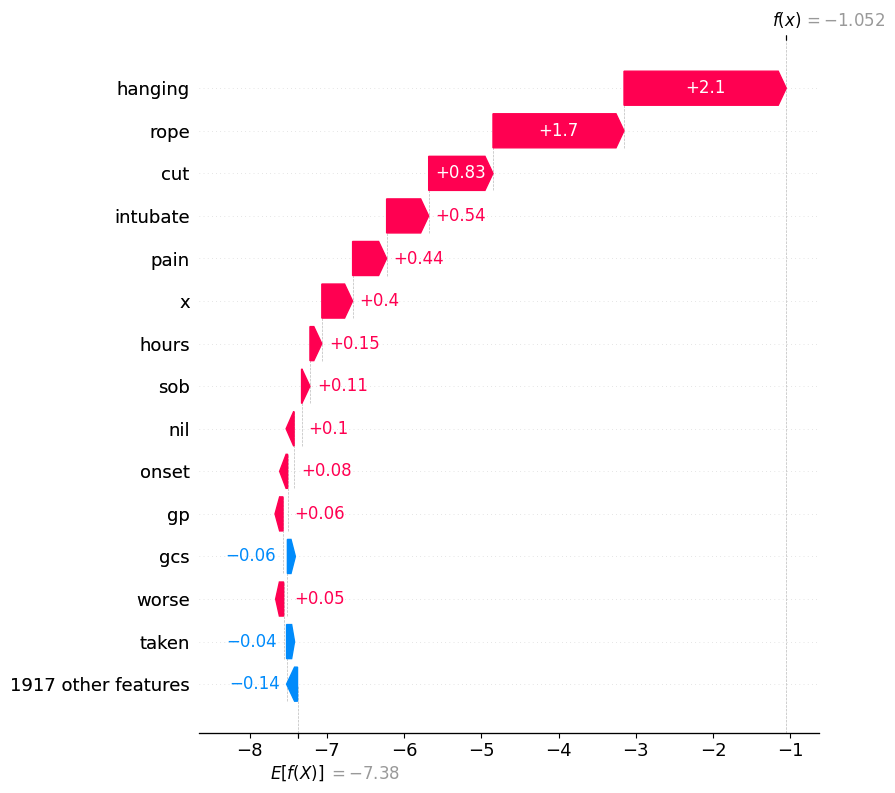

In [181]:
for name in ["test", "prsp", "external"]:
    miss_idx, proba, y_pred = get_misclassified(name, LABEL_COL, TEXT_COL, threshold)
    display(HTML(f"<h4>\n{name} set: {len(miss_idx)} misclassified cases</h4><br>"))

    for i in miss_idx[0:3]:
        explain_one_case(best_model, name, i, TEXT_COL, LABEL_COL, proba, y_pred, max_display=15)